<a href="https://colab.research.google.com/github/walid101/TicTacToe_RL/blob/master/ImageColorizerColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **<font color='blue'> Artistic Colorizer </font>**

#◢ DeOldify - Colorize your own photos!

####**Credits:**

Special thanks to:

Jason Antic for creating the DeOldify for training and inferencing.

Matt Robinson and María Benavente for pioneering the DeOldify image colab notebook.  

Dana Kelley for doing things, breaking stuff & having an opinion on everything.



---


#◢ Verify Correct Runtime Settings

**<font color='#FF000'> IMPORTANT </font>**

In the "Runtime" menu for the notebook window, select "Change runtime type." Ensure that the following are selected:
* Runtime Type = Python 3
* Hardware Accelerator = GPU


In [1]:
import torch

if not torch.cuda.is_available():
    print('GPU not available.')

#◢ Git clone and install DeOldify

In [2]:
!git clone https://github.com/Dakini/AnimeColorDeOldify.git DeOldify

fatal: destination path 'DeOldify' already exists and is not an empty directory.


In [3]:
cd DeOldify

/content/DeOldify


#◢ Setup

In [4]:
!pip install -r colab_requirements.txt

In [5]:
!pip install protobuf==3.20.3 -q

In [8]:
import torch
import collections
import collections.abc # Make sure abc is imported

# --- Apply the collections patch FIRST ---
print("Applying collections patch...")
for type_name in ['Iterable', 'Sized', 'Mapping', 'MutableMapping', 'MutableSequence', 'Sequence']:
    # Check if the main 'collections' module lacks the attribute
    if not hasattr(collections, type_name):
        # If missing, get it from 'collections.abc' and add it to 'collections'
        try:
            abc_attr = getattr(collections.abc, type_name)
            setattr(collections, type_name, abc_attr)
            print(f"  Patched collections.{type_name}")
        except AttributeError:
            print(f"  Warning: collections.abc.{type_name} not found, skipping patch.")
print("Collections patch applied.")

# --- NOW import fastai and deoldify ---
try:
    print("Importing fastai...")
    import fastai
    print("Importing deoldify.visualize...")
    from deoldify.visualize import *
    print("Imports successful!")

    # Set benchmark after imports are successful
    torch.backends.cudnn.benchmark = True
    print("torch.backends.cudnn.benchmark set to True.")

except ImportError as e:
    print(f"\n!!! Import Error occurred: {e}")
    print("Make sure requirements are installed and the collections patch ran successfully.")
except Exception as e:
    print(f"\n!!! An unexpected error occurred during import: {e}")
    import traceback
    traceback.print_exc()

# --- You can now proceed with the rest of your code ---
# e.g., defining stats, loading the colorizer (using the context manager patch for torch.load)

Applying collections patch...
  Patched collections.Iterable
  Patched collections.Sized
  Patched collections.Mapping
  Patched collections.MutableMapping
  Patched collections.MutableSequence
  Patched collections.Sequence
Collections patch applied.
Importing fastai...
Importing deoldify.visualize...
Imports successful!
torch.backends.cudnn.benchmark set to True.


In [9]:
!mkdir 'models'
!wget https://www.dropbox.com/s/0m1rwdk7je1r39j/MQT9QHUfXxKpQ9b2CPda89htDBzFtmHD9r2YZsHp.pth?dl=0 -O ./models/ColorizeArtistic_gen.pth

mkdir: cannot create directory ‘models’: File exists
--2025-04-19 01:13:33--  https://www.dropbox.com/s/0m1rwdk7je1r39j/MQT9QHUfXxKpQ9b2CPda89htDBzFtmHD9r2YZsHp.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6gqv8pw57gsx74md3g1v8/MQT9QHUfXxKpQ9b2CPda89htDBzFtmHD9r2YZsHp.pth?rlkey=ue5mg79a62meskktdrgm88iyv&dl=0 [following]
--2025-04-19 01:13:34--  https://www.dropbox.com/scl/fi/6gqv8pw57gsx74md3g1v8/MQT9QHUfXxKpQ9b2CPda89htDBzFtmHD9r2YZsHp.pth?rlkey=ue5mg79a62meskktdrgm88iyv&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbd8d3ae6ef156456d4c9eb8180.dl.dropboxusercontent.com/cd/0/inline/CoHZrgy9SombPnDopF1PdtpybBhJa0e0aC2dk1dDssZ8fuUS2Xp0byqxh2FFQdyUOH9npsq8mT2l01PXzQAUxbMzwF6aozT_GBeJN65FW

In [10]:
stats = ([0.7137, 0.6628, 0.6519],[0.2970, 0.3017, 0.2979])

In [11]:
import torch
import collections
import collections.abc
from contextlib import contextmanager

# --- Previous Setup Code ---
# Ensure GPU is available, clone repo, install requirements, download model, define stats...
# Make sure 'stats' variable is defined from the DeOldify notebook cell before this point.
# Example stats line (replace with actual from notebook if different):
# stats = ([0.7137, 0.6628, 0.6519],[0.2970, 0.3017, 0.2979])

# Also include the fastai/deoldify imports needed for get_image_colorizer
# Assuming you've already done:
# cd DeOldify
# import fastai
# from deoldify.visualize import *
# torch.backends.cudnn.benchmark = True
# --- End of Previous Setup ---


# 1. Fix the missing collections attributes (you already have this)
for type_name in ['Iterable', 'Sized', 'Mapping', 'MutableMapping', 'MutableSequence', 'Sequence']:
    if not hasattr(collections, type_name):
        setattr(collections, type_name, getattr(collections.abc, type_name))

# 2. Define the Context Manager to temporarily patch torch.load
@contextmanager
def temp_patch_torch_load():
    original_loader = torch.load  # Store the current torch.load

    # Define the temporary replacement function
    def patched_loader(f, *args, **kwargs):
        # Force weights_only=False
        kwargs_copy = dict(kwargs) # Use a copy
        kwargs_copy['weights_only'] = False
        # Call the loader that was active *before* entering the context
        return original_loader(f, *args, **kwargs_copy)

    try:
        torch.load = patched_loader # Apply the patch globally *temporarily*
        yield # Let the code inside the 'with' block run
    finally:
        torch.load = original_loader # IMPORTANT: Restore the original function afterwards

# 3. Use the context manager when loading the colorizer
print("Attempting to load colorizer with temporary patch...")
try:
    with temp_patch_torch_load():
        # This call will use the patched_loader internally
        colorizer = get_image_colorizer(artistic=True, stats=stats)
    print("Colorizer loaded successfully!")

    # Now you can use the colorizer as before
    # Example:
    # source_url = '...'
    # render_factor = 12
    # if source_url:
    #    image_path = colorizer.plot_transformed_image_from_url(url=source_url, render_factor=render_factor, compare=True, post_process=False, watermarked=False)
    #    show_image_in_notebook(image_path)

except Exception as e:
    print(f"An error occurred during colorizer loading: {e}")
    import traceback
    traceback.print_exc()

Attempting to load colorizer with temporary patch...


/usr/local/lib/python3.11/dist-packages/fastai/data_block.py:442: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")
/usr/local/lib/python3.11/dist-packages/fastai/data_block.py:444: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  warn("""Your validation set is empty. If this is by design, use `split_none()`
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid 

Colorizer loaded successfully!


#◢ Instructions

### source_url
Type in a url to a direct link of an image.  Usually that means they'll end in .png, .jpg, etc. NOTE: If you want to use your own image, upload it first to a site like Imgur.

### render_factor
The default value of 12 has been carefully chosen and should work -ok- for most scenarios (but probably won't be the -best-). This determines resolution at which the color portion of the image is rendered. Lower resolution will render faster, and colors also tend to look more vibrant. Older and lower quality images in particular will generally benefit by lowering the render factor. Higher render factors are often better for higher quality images, but the colors may get slightly washed out.

### watermarked
Selected by default, this places a watermark icon of a palette at the bottom left corner of the image.  This is intended to be a standard way to convey to others viewing the image that it is colorized by AI. We want to help promote this as a standard, especially as the technology continues to improve and the distinction between real and fake becomes harder to discern. This palette watermark practice was initiated and lead by the company MyHeritage in the MyHeritage In Color feature (which uses a newer version of DeOldify than what you're using here).

### post_process
Selected by default, this outputs the image without being postprocessed. The post processing usually works really well for images that contain some shading, however it does not work for images that are mainly line drawings (sketches). It is recommended to turn this off, if you are colorising a sketch.

#### How to Download a Copy
Simply right click on the displayed image and click "Save image as..."!

## Pro Tips

You can evaluate how well the image is rendered at each render_factor by using the code at the bottom (that cell under "See how well render_factor values perform on a frame here").

## Troubleshooting
If you get a 'CUDA out of memory' error, you probably have the render_factor too high.

#◢ Colorize!!

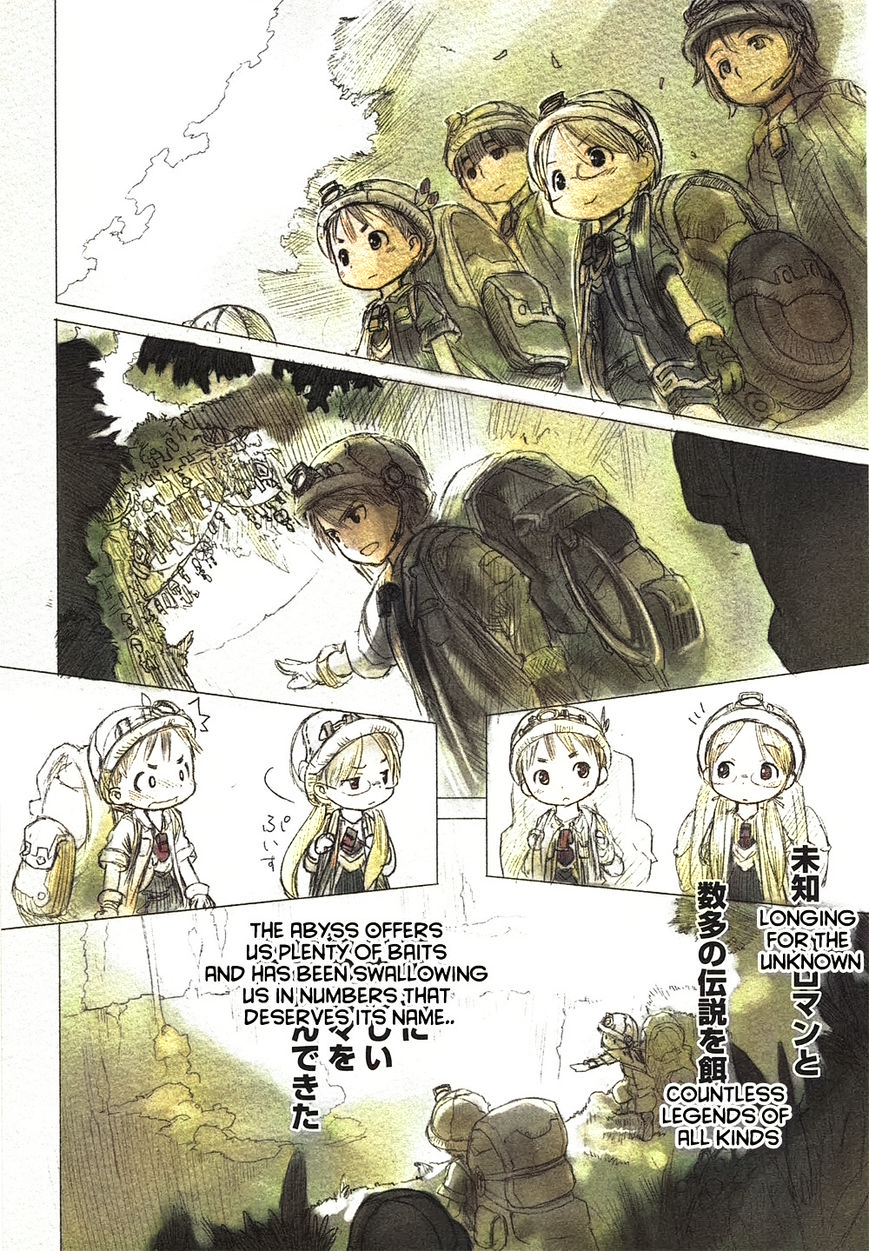

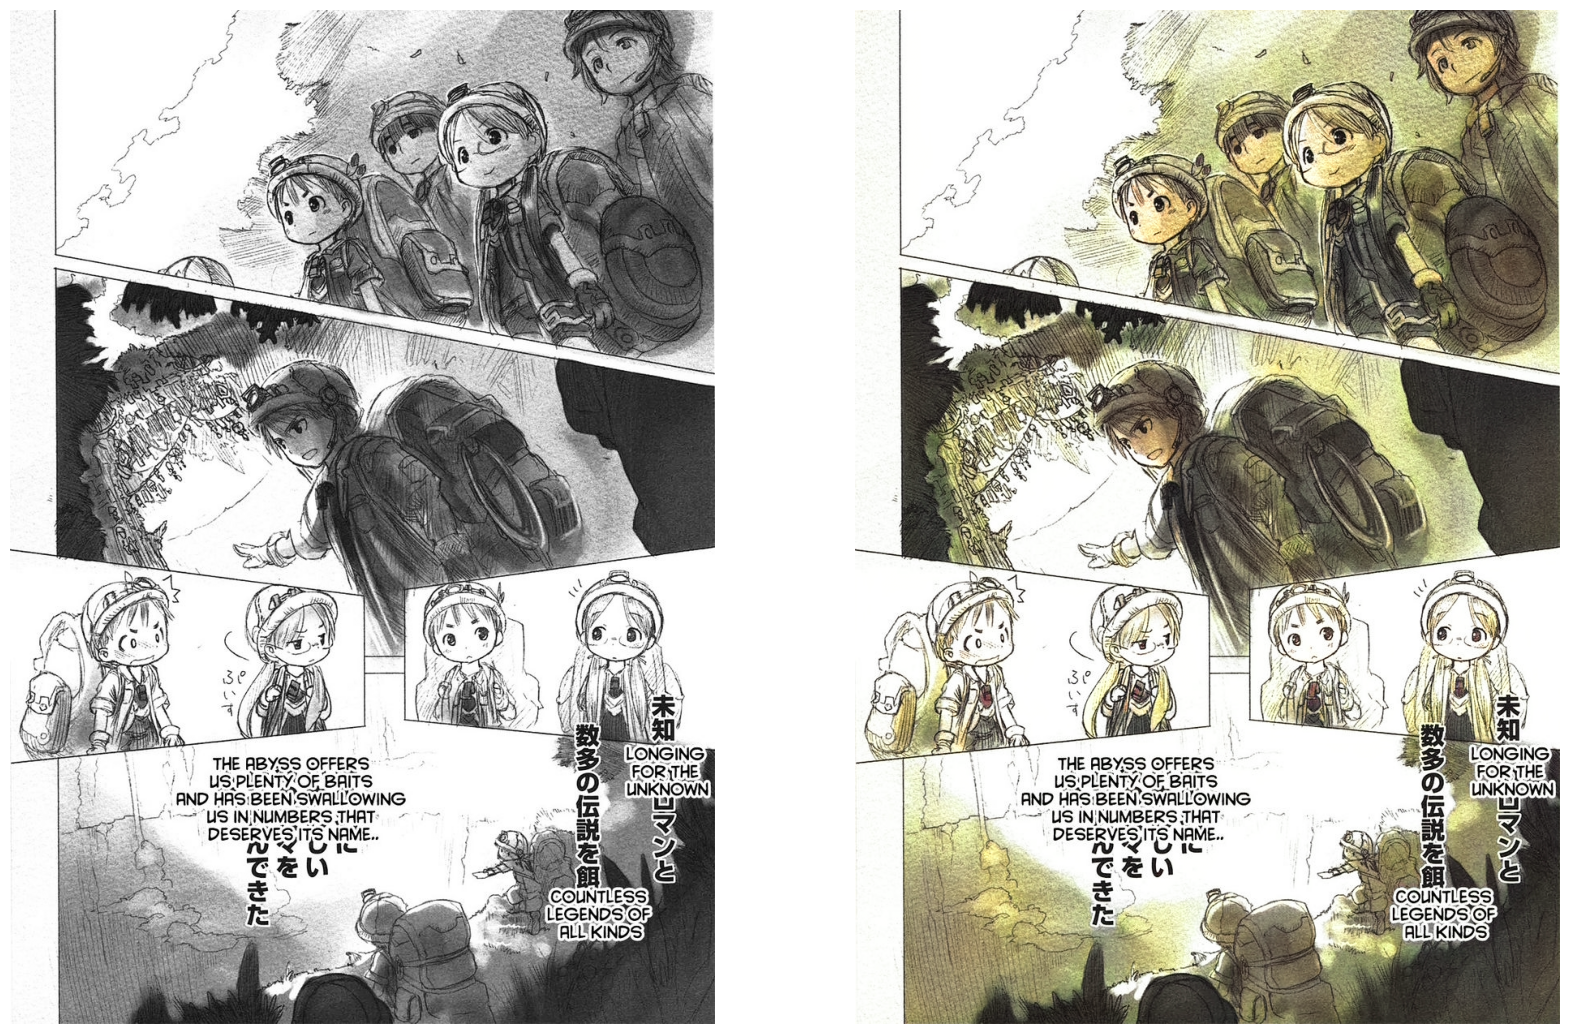

In [12]:
source_url = 'https://cmdxd98sb0x3yprd.mangadex.network/data/b4a19c73bbc9bef2feb86de24969d21f/x15-1f23e18a9271931f6d2e5290858f826a01004719a5dadab3e0e4d71384a9164c.jpg' # 'https://i.imgur.com/jUCRFJE.png' #@param {type:"string"}
render_factor = 35 #@param {type:"slider", min:7, max:45, step:1}
watermarked = False #@param {type:"boolean"}

if source_url is not None and source_url !='':
    image_path = colorizer.plot_transformed_image_from_url(url=source_url, render_factor=render_factor, compare=True, post_process=True, watermarked=watermarked)
    show_image_in_notebook(image_path)
else:
    print('Provide an image url and try again.')

## See how well render_factor values perform on the image here

In [ ]:
for i in range(10,45,2):
    colorizer.plot_transformed_image('test_images/5694_.png', render_factor=i, display_render_factor=True, post_process=True, figsize=(8,8))